# K-Means Clustering on Stock Data By Annual Returns and Volatility

I will be creating a script analyze data from the S&P 500 stocks, calculate their historic returns and volatility and then proceed to use the K-Means clustering algorithm to divide the stocks into distinct groups based upon said returns and volatilities.

So why would we want to do this you ask? Well dividing stocks into groups with “similar characteristics” can help in portfolio construction to ensure we choose a universe of stocks with sufficient diversification between them.

In [255]:
import numpy as np
import pandas as pd
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from scipy.stats import zscore

In [256]:
# Load the raw data from CSV
raw_data = pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\K-Means\all_stocks_5yr.csv")

# Group the data by 'Name'
grouped_data = raw_data.groupby('Name')

# Initialize lists to store calculated values
stock_names = []
returns = []
volatilities = []

# Calculate annual returns and volatility for each stock
for name, group in grouped_data:
    stock_names.append(name)
    # Calculate daily percentage changes
    daily_returns = group['close'].pct_change()
    # Calculate annualized return and volatility
    annual_return = daily_returns.mean() * 252
    annual_volatility = daily_returns.std() * sqrt(252)
    returns.append(annual_return)
    volatilities.append(annual_volatility)

# Create a DataFrame with the calculated values
stocks = pd.DataFrame({
    'Name': stock_names,
    'Return': returns,
    'Volatility': volatilities
})

# Remove duplicates based on the 'Name' column
stocks.drop_duplicates(subset=['Name'], keep='first', inplace=True)

# Display the DataFrame
print(stocks.head())

   Name    Return  Volatility
0     A  0.114232    0.245766
1   AAL  0.313831    0.356484
2   AAP  0.111748    0.300951
3  AAPL  0.198122    0.231657
4  ABBV  0.264656    0.267586


## Checking for Outliers using the Z-score Method

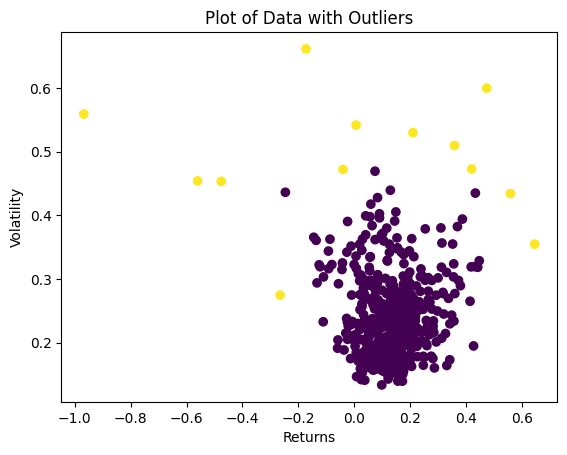

In [257]:
z_scores = np.abs(zscore(stocks[['Return', 'Volatility']]))
outliers = (z_scores > 3).any(axis=1)  # Define threshold for outliers

# Mark outliers in the plot
plt.scatter(stocks['Return'], stocks['Volatility'], c=outliers)

plt.title("Plot of Data with Outliers")
plt.xlabel("Returns")
plt.ylabel("Volatility")
plt.show()

In [258]:
# Removing Outliers
stocks = stocks[~outliers]
stocks

,Name,Return,Volatility
0,A,0.114232,0.245766
1,AAL,0.313831,0.356484
2,AAP,0.111748,0.300951
3,AAPL,0.198122,0.231657
4,ABBV,0.264656,0.267586
...,...,...,...
500,XYL,0.218813,0.217307
501,YUM,0.078037,0.262071
502,ZBH,0.114916,0.207924
503,ZION,0.195198,0.259674


## Using the Elbow Method to Determine the Number of Clusters

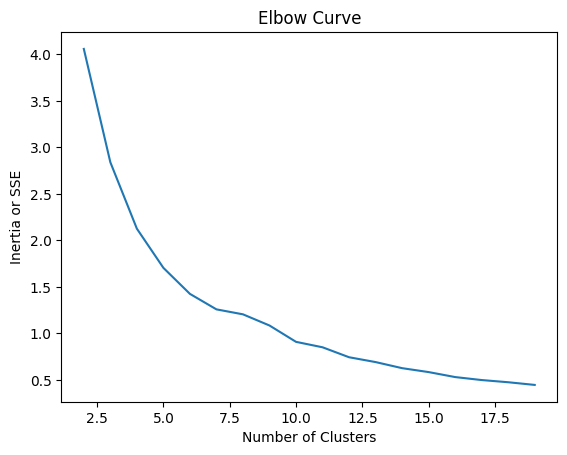

In [259]:
X = stocks[['Return', 'Volatility']].values
#Intertia is the Sum of Squared Error
inertia = []
for k in range(2,20):
    kmeans=KMeans(n_clusters=k, n_init = 'auto', random_state=100)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

#plotting Data

plt.plot(range(2,20),inertia)
plt.title("Elbow Curve")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia or SSE")
plt.show()

It is a bit hard to tell exactly what the best number of clusters is, it looks like it might be somewhere between 5 and 6.

## Using the Silhouette Method to Determine the Number of Clusters

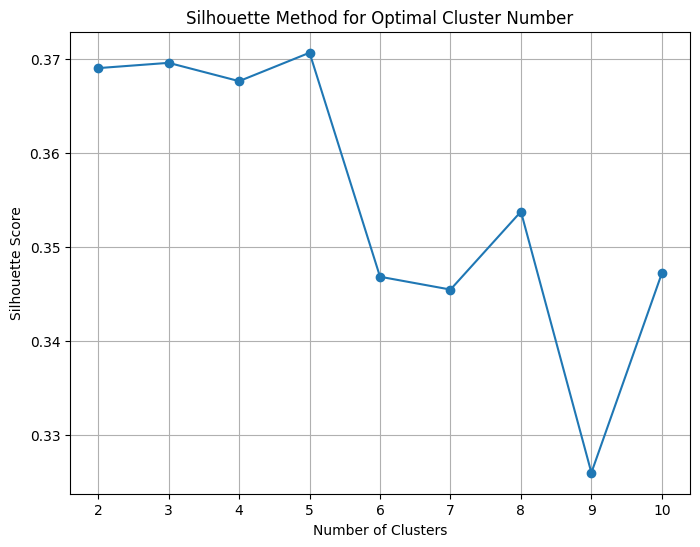

In [260]:
# Find the optimal number of clusters using the Silhouette Method
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=100)
    cluster_labels = kmeans.fit_predict(stocks[['Return', 'Volatility']])
    silhouette_avg = silhouette_score(stocks[['Return', 'Volatility']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette scores for different cluster numbers
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title("Silhouette Method for Optimal Cluster Number")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

Here we can see that the optimal number of clusters is 5.

## Creating K-Means Model

In [261]:
#Creating the model and labeling each stock into it's cluster
kmeans = KMeans(n_clusters=5).fit(X)
clusters = kmeans.labels_
stocks['Clusters'] = clusters
stocks.head

c:\Users\Ethan Scott\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<bound method NDFrame.head of      Name    Return  Volatility  Clusters
0       A  0.114232    0.245766         0
1     AAL  0.313831    0.356484         4
2     AAP  0.111748    0.300951         3
3    AAPL  0.198122    0.231657         2
4    ABBV  0.264656    0.267586         4
..    ...       ...         ...       ...
500   XYL  0.218813    0.217307         2
501   YUM  0.078037    0.262071         0
502   ZBH  0.114916    0.207924         0
503  ZION  0.195198    0.259674         2
504   ZTS  0.186295    0.224500         2

[492 rows x 4 columns]>

Text(0, 0.5, 'Volatility')

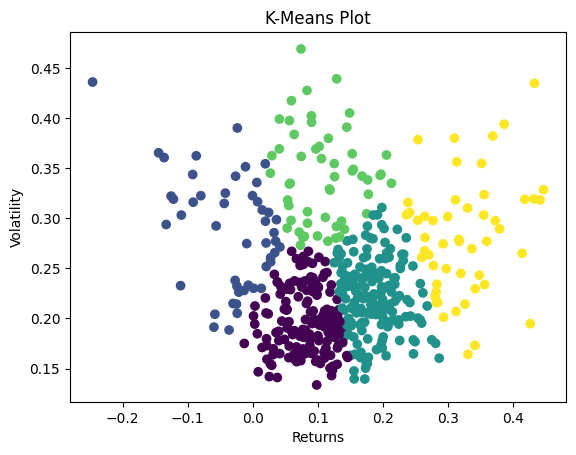

In [262]:
# Plotting the clusters
plt.scatter(X[:,0],X[:,1], c=clusters)
plt.title("K-Means Plot")
plt.xlabel("Returns")
plt.ylabel("Volatility")

## Creating a Porftolio with 1 Stock from Each cluster

In [263]:

# Define the portfolio function
def portfolio():
    # Count the number of stocks in each cluster
    cluster_counts = stocks['Clusters'].value_counts().sort_index()

    # Initialize a list to store selected stocks
    selected_stocks = []

    # Iterate through each cluster and randomly select exactly one stock
    for cluster in cluster_counts.index:
        # Select stocks from the cluster
        stocks_from_cluster = stocks[stocks['Clusters'] == cluster]

        # Shuffle the stocks within the cluster
        shuffled_stocks = stocks_from_cluster.sample()

        # Select the first stock from the shuffled list
        selected_stocks_from_cluster = shuffled_stocks.head(1)

        selected_stocks.append(selected_stocks_from_cluster)

    # Concatenate the list of selected stocks DataFrames
    selected_stocks_df = pd.concat(selected_stocks)
    
    # Display the selected portfolio
    print("Selected Portfolio:")
    print(selected_stocks_df)


In [264]:
portfolio()

Selected Portfolio:
     Name    Return  Volatility  Clusters
148   DUK  0.027102    0.154708         0
178     F -0.013284    0.227960         1
405   RTN  0.281388    0.175178         2
90   CELG  0.175351    0.304625         3
242  IDXX  0.297730    0.249684         4
